# Ajuste de datos a un modelo analítico y numérico

## Problema

Los datos contenidos en el archivo hamster_fibro_tumor.csv contiene la evolución en el tiempo del volumen de un tumor. La columna del tiempo está dada en días y la columna del volumen está en unidades de $\times 10^{9} \mu\text{m}^3$.

# El modelo logístico

El modelo logístico para el crecimiento de una población fue propuesto en 1845. Este modelo propone un decrecimiento lineal de la rapidez con que crece el tamaño de la población relativa al tamaño de la población
$$\frac{dV}{dt}=rV\left(1-\frac{V}{K}\right).$$
En esta ecuación, $r$ es una tasa de crecimiento per capita, $K$ se conoce como la capacidad de carga y es el valor máximo del tamaño de la población, impuesto por las limitaciones del entorno, como la cantidad limitada de recursos para que la población siga creciendo.


In [34]:
# Paquetes

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [11]:
# Lectura de datos

df = pd.read_csv('hamster_fibro_tumor.csv')
df.head(5)

,t,V
0,3.46,0.0158
1,4.58,0.0264
2,5.67,0.0326
3,6.64,0.0445
4,7.63,0.0646


In [12]:
# Redefinimos el tiempo

df['t'] = df['t']-df['t'][0]
df.head(5)

,t,V
0,0.00,0.0158
1,1.12,0.0264
2,2.21,0.0326
3,3.18,0.0445
4,4.17,0.0646


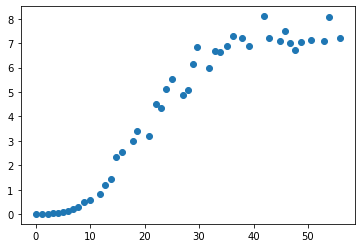

In [13]:
plt.scatter(df.t,df.V)

## 1. Ajuste de los datos a un modelo analítico

La solución analítica del modelo logistico es la siguiente
$$V=\frac{C e^{rt}}{1+(C/K)e^{rt}},\hspace{1cm} C=\frac{KV_0}{K-V_0},$$
Donde $V_0$ es el volumen inicial.

In [57]:
# Definimos el modelo como una función

def V_model(t, k, r):
    V0 = df.V[0]
    C = k*V0/(k-V0)
    V = C*np.exp(r*t)/(1+(C/k)*np.exp(r*t))
    return V

In [58]:
# Ajuste de la curva

# Definir los datos que se van a ajustar (t,y)
t_data = df['t'].values
V_data = df['V'].values

# Ajustar la curva
popt, _ = curve_fit(V_model, t_data, V_data) 

# Valores de los parámetros: k, r
k = popt[0]
r = popt[1]

# Valores de posición y predichos por el modelo
V_pred = V_model(t_data, k, r)

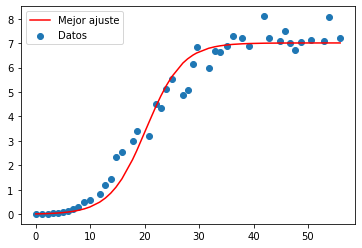

In [59]:
plt.scatter(t_data,V_data,label='Datos')
plt.plot(t_data,V_pred, color='red',label='Mejor ajuste')
plt.legend();

In [60]:
k

7.007523173005321

In [61]:
r

0.3000867649532339

## 2. Ajuste de los datos a un modelo numérico

Vamos a resolver el sistema por medio del Método de Heun (RK2)
$$V_{i+1}=V_{i}+\phi h, \hspace{1cm} \phi=\frac{1}{2}k_1 + \frac{1}{2}k_2,$$

$$k_1=f(V_i),$$
$$k_2=f(V_i+k_1 h),$$

siendo

$$f(V)=rV\left(1-\frac{V}{K}\right)$$

In [62]:
# Definimos la función f(V)

def f(V, k, r): return r*V*(1-(V/k)) 

In [63]:
# Definimos la solución numérica como una función

def V_num(t_value, k, r):
    t = np.linspace(0,65,4000)
    V_sol = []
    h = t[1] - t[0]
    V_prev = df.V[0]
    for i in range(len(t)):
        k1 = f(V_prev, k, r)
        k2 = f(V_prev + k1*h, k, r)
        phi = 0.5*k1 + 0.5*k2
        V_new = V_prev + phi*h
        V_sol.append(V_new)
        V_prev = V_new 
    V_interpol = interp1d(t,V_sol)
    return V_interpol(t_value)

In [64]:
# Ajuste de la curva

# Definir los datos que se van a ajustar (t,y)
t_data = df['t'].values
V_data = df['V'].values

# Ajustar la curva
popt, _ = curve_fit(V_num, t_data, V_data) 

# Valores de los parámetros: k, r
k = popt[0]
r = popt[1]

# Valores de posición y predichos por el modelo
V_pred = V_num(t_data, k, r)

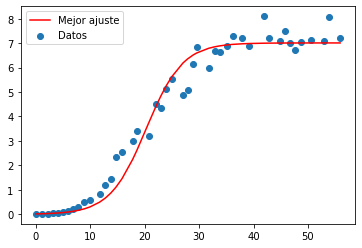

In [65]:
plt.scatter(t_data,V_data,label='Datos')
plt.plot(t_data,V_pred, color='red',label='Mejor ajuste')
plt.legend();

In [66]:
k

7.007900413980395

In [67]:
r

0.2998527319297056